In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import json



#### 1.0 Funciones útiles

In [37]:
def showPie(columna):
  count_values = pd.Series(columna).value_counts()
  if len(count_values) > 15:
    count_values = count_values.iloc[0:15]
  datos = pd.DataFrame({"valor":count_values.index, "ocurrencia": count_values.values})

  plt.title(columna.name)
  plt.pie(datos["ocurrencia"], labels=datos['valor'], autopct='%1.1f%%')
  plt.show()

def concatenar(data_1, data_2,  axis=1):
  return pd.concat([data_1, data_2], axis=axis)

def contar_nulos(data):
  return data.isna().sum()

def mapear(columna: pd.Series, mapa={'NO': 0, 'SI':1}):
  return columna.map(mapa)

def showPiePx(columna, max=15, pref="", title=""):
  count_values = pd.Series(columna).value_counts()
  if len(count_values) > max:
    count_values = count_values.iloc[0:max]
  count_values.index = count_values.index.astype('str') + pref
  datos = pd.DataFrame({"valor":count_values.index, "ocurrencia": count_values.values})
  fig = px.pie(datos, values='ocurrencia', names='valor', title=title)
  fig.update_traces(textposition='outside', textinfo='percent+label')
  fig.show()
  
def nulos_filas(data):
    return pd.DataFrame(data.isna().sum(axis=1).value_counts().reset_index().values, columns=['cant_col_nulas', 'cantidad'])
  

## 1.1 Extracción, Transformación y Carga de Datos (ETL)

### 1.1.1 Extracción

In [38]:
data_hm = pd.read_excel('data/homicidios.xlsx', sheet_name='HECHOS')
data_vh = pd.read_excel('data/homicidios.xlsx', sheet_name='VICTIMAS')
data_le = pd.read_excel('data/lesiones.xlsx', sheet_name='HECHOS')
data_lv = pd.read_excel('data/lesiones.xlsx', sheet_name='VICTIMAS')

### 1.1.2 Transformación

#### 1.1.2.1 Análisis de Nulos

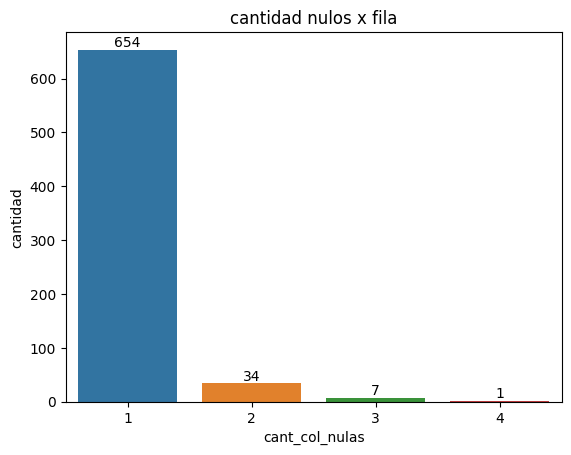

In [8]:
# Devuelve la cantidad filas que tienen la por cantidad de columnas nulas, es decir, 
# hay 88.310 filas que tienen 13 valores nulos, hay 22.530 filas que tienen 0 valores nulos

ax = sns.barplot(x=nulos_filas(data_).cant_col_nulas, y=nulos_filas(data_).cantidad)
for i in ax.containers:
    ax.bar_label(i,)
plt.title("cantidad nulos x fila")
plt.show()

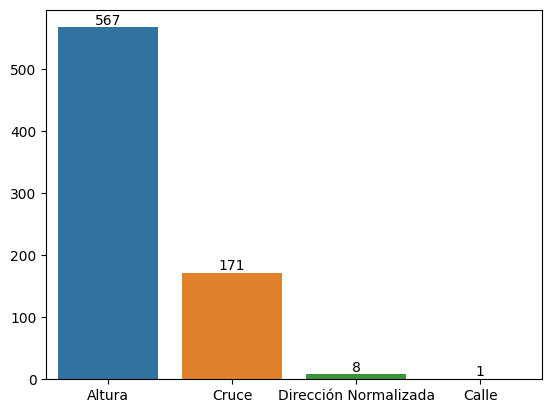

In [9]:
nulos_columnas = data_.isna().sum()[data_.isna().sum() > 0].sort_values(ascending=False)
ax = sns.barplot(x=nulos_columnas.index, y=nulos_columnas.values)
for i in ax.containers:
    ax.bar_label(i,)

In [10]:
# la cantidad de filas del data frame es igual a la cantidad de filas que tiene un al menos un valor nulo
len(data_), len(data_.isna().T.sum())

(696, 696)

Después de hacer un oversight sobre el dataset, vemos que Altura y Cruce son excluyentes, cuando está definida la altura es porque es sobre una calle propia y en caso contrario es una esquina. Por lo tanto, vamos a excluirlas del análisis de nulos.

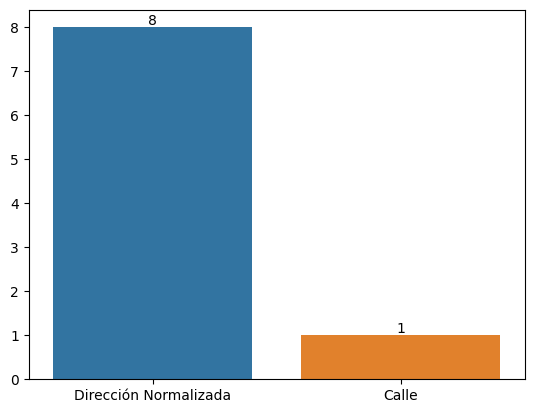

In [6]:
data_sin_altura_cruce = data_[data_.columns[~data_.columns.isin(['Cruce', 'Altura'])]]
nulos_columnas = data_sin_altura_cruce.isna().sum()[data_sin_altura_cruce.isna().sum() > 0].sort_values(ascending=False)
ax = sns.barplot(x=nulos_columnas.index, y=nulos_columnas.values)
for i in ax.containers:
    ax.bar_label(i,)

In [7]:
data_[data_.isna().iloc[:, 13]].head(3)

ID  N_VICTIMAS      FECHA  AAAA  MM  DD      HORA  HH  \
38   2016-0052           1 2016-04-20  2016   4  20  20:00:00  20   
106  2016-0136           1 2016-10-25  2016  10  25  00:00:00   0   
119  2016-0151           1 2016-11-18  2016  11  18  20:35:00  20   

                      LUGAR_DEL_HECHO TIPO_DE_CALLE  ... Altura  Cruce  \
38         AUTOPISTA LUGONES PK 10000     AUTOPISTA  ...    NaN    NaN   
106  AU BUENOS AIRES - LA PLATA KM. 4     AUTOPISTA  ...    NaN    NaN   
119                                SD         CALLE  ...    NaN    NaN   

    Dirección Normalizada COMUNA    XY (CABA) pos x pos y PARTICIPANTES  \
38                    NaN     13  Point (. .)     .     .       MOTO-SD   
106                   NaN      4  Point (. .)     .     .   MOTO-CARGAS   
119                   NaN      0  Point (. .)     .     .     PEATON-SD   

    VICTIMA ACUSADO  
38     MOTO      SD  
106    MOTO  CARGAS  
119  PEATON      SD  

[3 rows x 21 columns]

In [8]:
data_[data_.isna().iloc[:, 10]]

ID  N_VICTIMAS      FECHA  AAAA  MM  DD      HORA  HH  \
119  2016-0151           1 2016-11-18  2016  11  18  20:35:00  20   

    LUGAR_DEL_HECHO TIPO_DE_CALLE  ... Altura  Cruce Dirección Normalizada  \
119              SD         CALLE  ...    NaN    NaN                   NaN   

    COMUNA    XY (CABA) pos x pos y PARTICIPANTES VICTIMA ACUSADO  
119      0  Point (. .)     .     .     PEATON-SD  PEATON      SD  

[1 rows x 21 columns]

Según lo visto, cuando la direcciòn normalizada es nula es porque ocurre en autopista, sólo un caso en el que es calle porque es un registro con valores nulos o sin datos, del que se puede prescindir.

Vemos que hay otros valores nulos encubiertos, como ```'.'``` en las coordenadas GPS, o ```Point (. .)```, en las otras coordenads espaciales, o ```SD``` en otros campos. Inclusive ```0``` en la columna ```COMUNA```, siendo 15 comunas a partir de la 1.

In [9]:
# data_['pos x'].apply(lambda x: float(x) if x.lstrip().isnumeric() else None)
data_['pos x'] = data_['pos x'].apply(lambda x: np.nan if x == '.' else float(x))
data_['pos y'] = data_['pos y'].apply(lambda x: np.nan if x == '.' else float(x))


In [18]:
data_['pos x'].fillna(data_['pos x'].mean(), inplace=True)
data_['pos y'].fillna(data_['pos y'].mean(), inplace=True)

C:\Users\javier\AppData\Local\Temp\ipykernel_32088\2987834273.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_['pos x'].fillna(data_['pos x'].mean(), inplace=True)
C:\Users\javier\AppData\Local\Temp\ipykernel_32088\2987834273.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a co

In [26]:
type(data_['PARTICIPANTES'][0])

str

In [36]:
import json
coordinates = [data_['pos x'].sample(1).values[0], data_['pos y'].sample(2).values[0]]

# Create a GeoJSON point feature
point_geojson = [{
    "type": "Feature",
    "geometry": {
        "type": "Point",
        "coordinates": [x, y]
    },
    "properties": {"participantes" : str(p), 'direccion': str(d)}
} for x, y, p, d in zip(data_['pos x'].values, data_['pos y'].values, data_['PARTICIPANTES'].values, data_['Dirección Normalizada'].values)]

# Convert the GeoJSON to a JSON string
point_geojson_str = json.dumps(point_geojson)

# pd.DataFrame(point_geojson)

json_file_path = "data/generated/output.json"

# Write the data to the JSON file
with open(json_file_path, "w") as json_file:
    json.dump(point_geojson, json_file, indent=4) 

In [16]:
data_['pos x'].mean()

-58.441545233561044

In [17]:
data_['pos y'].mean()

-34.61963157034328

In [16]:
data_.groupby(['AAAA','COMUNA']).sum(['N_VICTIMAS'])

N_VICTIMAS   MM   DD  Altura        pos x       pos y
AAAA COMUNA                                                       
2016 0                2   23   45     0.0     0.000000    0.000000
     1               22  134  308  6510.0 -1284.381781 -761.551055
     2                1    5   22     0.0   -58.390566  -34.584186
     3                8   57  165     0.0  -467.214492 -276.938161
     4               16  125  257  7168.0  -875.933930 -519.644371
...                 ...  ...  ...     ...          ...         ...
2021 11               5   45   62  8726.0  -292.523626 -173.061868
     12               7   39  124     0.0  -409.485369 -241.904724
     13               7   45   89  5958.0  -409.187759 -241.867431
     14               4   19   66  3428.0  -233.657809 -138.309693
     15               5   16   77  5783.0  -292.365246 -172.961740

[91 rows x 6 columns]

In [17]:
# data_['Dirección Normalizada'][data_['Dirección Normalizada'].isna()] = data_['LUGAR_DEL_HECHO'][data_['Dirección Normalizada'].isna()].copy()

In [18]:
data_['Dirección Normalizada'].isna().sum()

8

In [20]:
nulos = [idx for idx, value in enumerate(data_['Dirección Normalizada'].isna()) if value]
for i in nulos:
    data_['Dirección Normalizada'].iloc[i] = data_['LUGAR_DEL_HECHO'].iloc[i]


C:\Users\SistemasRC\AppData\Local\Temp\ipykernel_4552\1211669495.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data_['Dirección Normalizada'].iloc[i] = data_['LUGAR_DEL_HECHO'].iloc[i]
C:\Users\SistemasRC\AppData\Local\Temp\ipykernel_4

In [21]:
nulos = [idx for idx, value in enumerate(data_['Dirección Normalizada'].isna()) if value]



In [22]:
data_['Dirección Normalizada'].fillna(data_['LUGAR_DEL_HECHO'], inplace=True)


C:\Users\SistemasRC\AppData\Local\Temp\ipykernel_4552\130466963.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_['Dirección Normalizada'].fillna(data_['LUGAR_DEL_HECHO'], inplace=True)


In [23]:
data_['Altura'].fillna('esq', inplace=True)

C:\Users\SistemasRC\AppData\Local\Temp\ipykernel_4552\505666676.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_['Altura'].fillna('esq', inplace=True)
C:\Users\SistemasRC\AppData\Local\Temp\ipykernel_4552\505666676.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'esq' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data_['Altura'].fillna('esq', inplace=True)


In [24]:
data_['Altura'].fillna('NA', inplace=True)

In [25]:
data_['Dirección Normalizada'].value_counts()

Dirección Normalizada
27 DE FEBRERO AV. y ESCALADA AV.                         5
PAZ, GRAL. AV. y BALBIN, RICARDO, DR. AV.                4
PAZ, GRAL. AV. y DEL LIBERTADOR AV.                      4
CASTILLO, RAMON S., PRES. AV. y CALLE 12 (NO OFICIAL)    3
DEL LIBERTADOR AV. y RAMOS MEJIA, JOSE MARIA, DR. AV.    3
                                                        ..
GALLO y CORDOBA AV.                                      1
ARANGUREN, JUAN F., DR. 611                              1
AUTOPISTA PERITO MORENO y AUTOPISTA 25 DE MAYO           1
CHORROARIN y SAN MARTIN AV.                              1
PADRE CARLOS MUGICA 709                                  1
Name: count, Length: 643, dtype: int64

In [26]:
data_[data_['Calle'].isna()]

ID  N_VICTIMAS      FECHA  AAAA  MM  DD      HORA  HH  \
119  2016-0151           1 2016-11-18  2016  11  18  20:35:00  20   

    LUGAR_DEL_HECHO TIPO_DE_CALLE  ... Altura Cruce Dirección Normalizada  \
119              SD         CALLE  ...    esq   NaN                    SD   

    COMUNA    XY (CABA) pos x  pos y  PARTICIPANTES VICTIMA ACUSADO  
119      0  Point (. .)   NaN    NaN      PEATON-SD  PEATON      SD  

[1 rows x 21 columns]

In [27]:
data_['Dirección Normalizada'].isna().sum()

0

In [28]:
data_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 696 entries, 0 to 695
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ID                     696 non-null    object        
 1   N_VICTIMAS             696 non-null    int64         
 2   FECHA                  696 non-null    datetime64[ns]
 3   AAAA                   696 non-null    int64         
 4   MM                     696 non-null    int64         
 5   DD                     696 non-null    int64         
 6   HORA                   696 non-null    object        
 7   HH                     696 non-null    object        
 8   LUGAR_DEL_HECHO        696 non-null    object        
 9   TIPO_DE_CALLE          696 non-null    object        
 10  Calle                  695 non-null    object        
 11  Altura                 696 non-null    object        
 12  Cruce                  525 non-null    object        
 13  Direc

In [30]:
# data_.iloc[data_['Dirección Normalizada'].isna(), 13] = data_.iloc[data_['Dirección Normalizada'].isna(), 8].values

In [31]:

data = data_.set_index(data_.ID)
data.drop('ID', axis=1, inplace=True,errors='ignore')
data

N_VICTIMAS      FECHA  AAAA  MM  DD      HORA  HH  \
ID                                                             
2016-0001           1 2016-01-01  2016   1   1  04:00:00   4   
2016-0002           1 2016-01-02  2016   1   2  01:15:00   1   
2016-0003           1 2016-01-03  2016   1   3  07:00:00   7   
2016-0004           1 2016-01-10  2016   1  10  00:00:00   0   
2016-0005           1 2016-01-21  2016   1  21  05:20:00   5   
...               ...        ...   ...  ..  ..       ...  ..   
2021-0093           1 2021-12-13  2021  12  13  17:10:00  17   
2021-0094           1 2021-12-20  2021  12  20  01:10:00   1   
2021-0095           1 2021-12-30  2021  12  30  00:43:00   0   
2021-0096           1 2021-12-15  2021  12  15  10:30:00  10   
2021-0097           1 2021-11-18  2021  11  18  06:10:00   6   

                                     LUGAR_DEL_HECHO TIPO_DE_CALLE  \
ID                                                                   
2016-0001  AV PIEDRA BUENA Y AV FERNANDEZ DE LA CRUZ       AVENIDA   
2016-0002          AV GRAL PAZ  Y AV DE LOS CORRALES      GRAL PAZ   
2016-0003                         AV ENTRE RIOS 2034       AVENIDA   
2016-0004      AV LARRAZABAL Y GRAL VILLEGAS CONRADO       AVENIDA   
2016-0005  AV SAN JUAN Y PRESIDENTE LUIS SAENZ PEÑA        AVENIDA   
...                                              ...           ...   
2021-0093                          AV. RIESTRA Y MOM       AVENIDA   
2021-0094                    AU DELLEPIANE Y LACARRA     AUTOPISTA   
2021-0095                        AV. GAONA Y TERRADA       AVENIDA   
2021-0096                         AV. EVA PERON 4071       AVENIDA   
2021-0097                    PADRE CARLOS MUJICA 709         CALLE   

                                  Calle  Altura  \
ID                                                
2016-0001              PIEDRA BUENA AV.     esq   
2016-0002                PAZ, GRAL. AV.     esq   
2016-0003                ENTRE RIOS AV.  2034.0   
2016-0004                LARRAZABAL AV.     esq   
2016-0005                  SAN JUAN AV.     esq   
...                                 ...     ...   
2021-0093                   RIESTRA AV.     esq   
2021-0094  DELLEPIANE, LUIS, TTE. GRAL.     esq   
2021-0095                     GAONA AV.     esq   
2021-0096                PERON, EVA AV.  4071.0   
2021-0097           PADRE CARLOS MUJICA   709.0   

                                         Cruce  \
ID                                               
2016-0001  FERNANDEZ DE LA CRUZ, F., GRAL. AV.   
2016-0002                  DE LOS CORRALES AV.   
2016-0003                                  NaN   
2016-0004             VILLEGAS, CONRADO, GRAL.   
2016-0005              SAENZ PE?A, LUIS, PRES.   
...                                        ...   
2021-0093                                  MOM   
2021-0094                          LACARRA AV.   
2021-0095                              TERRADA   
2021-0096                                  NaN   
2021-0097                                  NaN   

                                       Dirección Normalizada  COMUNA  \
ID                                                                     
2016-0001  PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G...       8   
2016-0002               PAZ, GRAL. AV. y DE LOS CORRALES AV.       9   
2016-0003                                ENTRE RIOS AV. 2034       1   
2016-0004          LARRAZABAL AV. y VILLEGAS, CONRADO, GRAL.       8   
2016-0005            SAN JUAN AV. y SAENZ PEÃ‘A, LUIS, PRES.       1   
...                                                      ...     ...   
2021-0093                                  RIESTRA AV. y MOM       7   
2021-0094         DELLEPIANE, LUIS, TTE. GRAL. y LACARRA AV.       9   
2021-0095                                GAONA AV. y TERRADA      11   
2021-0096                                PERON, EVA AV. 4071       9   
2021-0097                            PADRE CARLOS MUGICA 709       1   

               

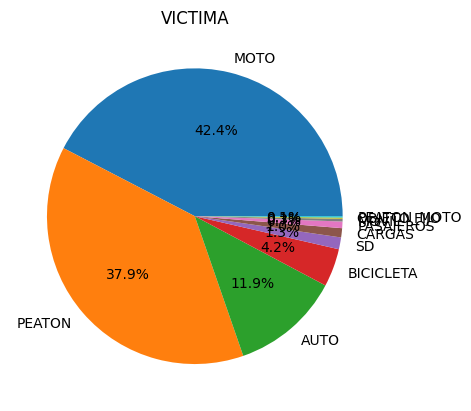

In [32]:
showPie(data['VICTIMA'])

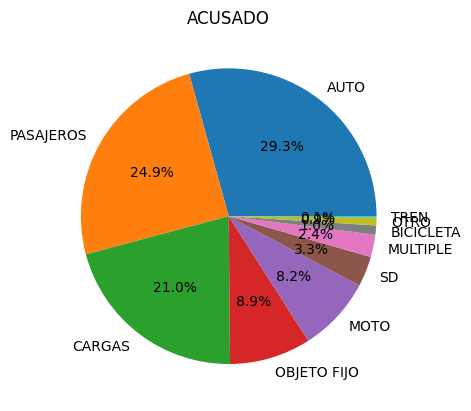

In [33]:
showPie(data['ACUSADO'])

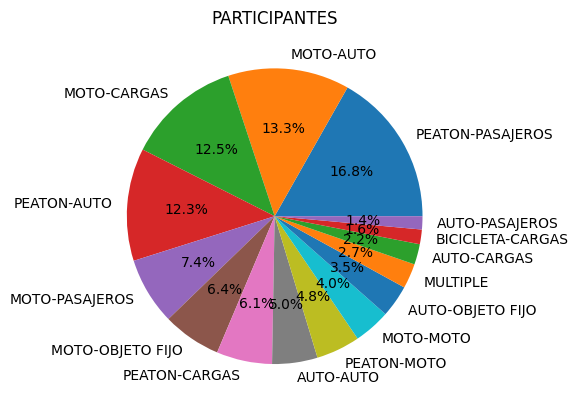

In [34]:
showPie(data['PARTICIPANTES'])

In [35]:
data.describe()

N_VICTIMAS                          FECHA         AAAA          MM  \
count  696.000000                            696   696.000000  696.000000   
mean     1.030172  2018-09-14 05:12:24.827586048  2018.188218    6.692529   
min      1.000000            2016-01-01 00:00:00  2016.000000    1.000000   
25%      1.000000            2017-04-02 12:00:00  2017.000000    4.000000   
50%      1.000000            2018-07-12 12:00:00  2018.000000    7.000000   
75%      1.000000            2020-01-04 06:00:00  2020.000000   10.000000   
max      3.000000            2021-12-30 00:00:00  2021.000000   12.000000   
std      0.179393                            NaN     1.683754    3.571309   

               DD      COMUNA       pos x       pos y  
count  696.000000  696.000000  684.000000  684.000000  
mean    15.936782    7.425287  -58.441545  -34.619632  
min      1.000000    0.000000  -58.529942  -34.705250  
25%      9.000000    4.000000  -58.476218  -34.643689  
50%     16.000000    8.000000  -58.444513  -34.622928  
75%     23.000000   11.000000  -58.401841  -34.596799  
max     31.000000   15.000000  -58.356082  -34.534654  
std      8.639646    4.387050    0.046144    0.035289

In [37]:
# data['ACUSADO'].corr(data['VICTIMA'])

In [38]:
barrios = pd.read_excel('data/barrios.xlsx')
len(barrios.dropna().BARRIO.unique())

48

In [39]:
comunas = pd.read_excel('data/comunas.xlsx')

comunas['barrios'] = comunas.BARRIOS.apply(lambda x: x.split(' - '))

# pd.merge(pd.DataFrame(comunas.barrios.explode()).reset_index(names='comuna_id'), comunas[['ID', 'COMUNAS']], left_on='comuna_id', right_on='ID')
comunas.set_index('COMUNAS', drop=True, inplace=True)
comunas.drop('ID', axis = 1, inplace=True, errors='ignore')
comunas.sort_index()

OBJETO                                            BARRIOS  \
COMUNAS                                                                      
1        LIMITE COMUNAL  CONSTITUCION - MONTSERRAT - PUERTO MADERO - RE...   
2        LIMITE COMUNAL                                           RECOLETA   
3        LIMITE COMUNAL                          BALVANERA - SAN CRISTOBAL   
4        LIMITE COMUNAL  BARRACAS - BOCA - NUEVA POMPEYA - PARQUE PATRI...   
5        LIMITE COMUNAL                                    ALMAGRO - BOEDO   
6        LIMITE COMUNAL                                          CABALLITO   
7        LIMITE COMUNAL                          FLORES - PARQUE CHACABUCO   
8        LIMITE COMUNAL     VILLA LUGANO - VILLA RIACHUELO - VILLA SOLDATI   
9        LIMITE COMUNAL            LINIERS - MATADEROS - PARQUE AVELLANEDA   
10       LIMITE COMUNAL  FLORESTA - MONTE CASTRO - VELEZ SARSFIELD - VE...   
11       LIMITE COMUNAL  VILLA DEL PARQUE - VILLA  DEVOTO - VILLA GRAL....   
12       LIMITE COMUNAL  COGHLAN - SAAVEDRA - VILLA PUEYRREDON - VILLA ...   
13       LIMITE COMUNAL                      BELGRANO - COLEGIALES - NUÑEZ   
14       LIMITE COMUNAL                                            PALERMO   
15       LIMITE COMUNAL  AGRONOMIA - CHACARITA -  PARQUE CHAS -  PATERN...   

            PERIMETRO          AREA  \
COMUNAS                               
1        36102.201573  1.779457e+07   
2        21452.838648  6.317265e+06   
3        10486.260809  6.385991e+06   
4        35423.282799  2.168464e+07   
5        12323.432479  6.660603e+06   
6        10990.964471  6.851029e+06   
7        17972.257870  1.242290e+07   
8        20935.012513  2.221690e+07   
9        21411.738344  1.650531e+07   
10       18332.037457  1.265656e+07   
11       19987.696155  1.412004e+07   
12       17232.189372  1.557093e+07   
13       26198.826953  1.471321e+07   
14       22126.531858  1.584587e+07   
15       17832.585580  1.432290e+07   

                                                   barrios  
COMUNAS                                                     
1        [CONSTITUCION, MONTSERRAT, PUERTO MADERO, RETI...  
2                                               [RECOLETA]  
3                               [BALVANERA, SAN CRISTOBAL]  
4        [BARRACAS, BOCA, NUEVA POMPEYA, PARQUE PATRICIOS]  
5                                         [ALMAGRO, BOEDO]  
6                                              [CABALLITO]  
7                               [FLORES, PARQUE CHACABUCO]  
8           [VILLA LUGANO, VILLA RIACHUELO, VILLA SOLDATI]  
9                  [LINIERS, MATADEROS, PARQUE AVELLANEDA]  
10       [FLORESTA, MONTE CASTRO, VELEZ SARSFIELD, VERS...  
11       [VILLA DEL PARQUE, VILLA  DEVOTO, VILLA GRAL. ...  
12       [COGHLAN, SAAVEDRA, VILLA PUEYRREDON, VILLA UR...  
13                           [BELGRANO, COLEGIALES, NUÑEZ]  
14                                               [PALERMO]  
15       [AGRONOMIA, CHACARITA,  PARQUE CHAS,  PATERNAL...

In [40]:
pd.merge(pd.DataFrame(comunas.barrios.explode()).reset_index(names='comuna_id'), comunas, left_on='comuna_id', right_on='COMUNAS')

comuna_id          barrios_x          OBJETO  \
0           2           RECOLETA  LIMITE COMUNAL   
1           5            ALMAGRO  LIMITE COMUNAL   
2           5              BOEDO  LIMITE COMUNAL   
3           6          CABALLITO  LIMITE COMUNAL   
4           7             FLORES  LIMITE COMUNAL   
5           7   PARQUE CHACABUCO  LIMITE COMUNAL   
6           9            LINIERS  LIMITE COMUNAL   
7           9          MATADEROS  LIMITE COMUNAL   
8           9  PARQUE AVELLANEDA  LIMITE COMUNAL   
9          10           FLORESTA  LIMITE COMUNAL   
10         10       MONTE CASTRO  LIMITE COMUNAL   
11         10    VELEZ SARSFIELD  LIMITE COMUNAL   
12         10          VERSALLES  LIMITE COMUNAL   
13         10         VILLA LURO  LIMITE COMUNAL   
14         10         VILLA REAL  LIMITE COMUNAL   
15         11   VILLA DEL PARQUE  LIMITE COMUNAL   
16         11      VILLA  DEVOTO  LIMITE COMUNAL   
17         11  VILLA GRAL. MITRE  LIMITE COMUNAL   
18         11   VILLA SANTA RITA  LIMITE COMUNAL   
19         12            COGHLAN  LIMITE COMUNAL   
20         12           SAAVEDRA  LIMITE COMUNAL   
21         12   VILLA PUEYRREDON  LIMITE COMUNAL   
22         12      VILLA URQUIZA  LIMITE COMUNAL   
23         14            PALERMO  LIMITE COMUNAL   
24          3          BALVANERA  LIMITE COMUNAL   
25          3      SAN CRISTOBAL  LIMITE COMUNAL   
26         15          AGRONOMIA  LIMITE COMUNAL   
27         15          CHACARITA  LIMITE COMUNAL   
28         15        PARQUE CHAS  LIMITE COMUNAL   
29         15           PATERNAL  LIMITE COMUNAL   
30         15       VILLA CRESPO  LIMITE COMUNAL   
31         15      VILLA ORTUZAR  LIMITE COMUNAL   
32          8       VILLA LUGANO  LIMITE COMUNAL   
33          8    VILLA RIACHUELO  LIMITE COMUNAL   
34          8      VILLA SOLDATI  LIMITE COMUNAL   
35          4           BARRACAS  LIMITE COMUNAL   
36          4               BOCA  LIMITE COMUNAL   
37          4      NUEVA POMPEYA  LIMITE COMUNAL   
38          4   PARQUE PATRICIOS  LIMITE COMUNAL   
39          1       CONSTITUCION  LIMITE COMUNAL   
40          1         MONTSERRAT  LIMITE COMUNAL   
41          1      PUERTO MADERO  LIMITE COMUNAL   
42          1             RETIRO  LIMITE COMUNAL   
43          1        SAN NICOLAS  LIMITE COMUNAL   
44          1          SAN TELMO  LIMITE COMUNAL   
45         13           BELGRANO  LIMITE COMUNAL   
46         13         COLEGIALES  LIMITE COMUNAL   
47         13              NUÑEZ  LIMITE COMUNAL   

                                              BARRIOS     PERIMETRO  \
0                                            RECOLETA  21452.838648   
1                                     ALMAGRO - BOEDO  12323.432479   
2                                     ALMAGRO - BOEDO  12323.432479   
3                                           CABALLITO  10990.964471   
4                           FLORES - PARQUE CHACABUCO  17972.257870   
5                           FLORES - PARQUE CHACABUCO  17972.257870   
6             LINIERS - MATADEROS - PARQUE AVELLANEDA  21411.738344   
7             LINIERS - MATADEROS - PARQUE AVELLANEDA  21411.738344   
8             LINIERS - MATADEROS - PARQUE AVELLANEDA  21411.738344   
9   FLORESTA - MONTE CASTRO - VELEZ SARSFIELD - VE...  18332.037457   
10  FLORESTA - MONTE CASTRO - VELEZ SARSFIELD - VE...  18332.037457   
11  FLORESTA - MONTE CASTRO - VELEZ SARSFIELD - VE...  18332.037457   
12  FLORESTA - MONTE CASTRO - VELEZ SARSFIELD - VE...  18332.037457   
13  FLORESTA - MONTE CASTRO - VELEZ SARSFIELD - VE...  18332.037457   
14  FLORESTA - MONTE CASTRO - VELEZ SARSFIELD - VE...  18332.037457   
15  VILLA DEL PARQUE - VILLA  DEVOTO - VILLA GRAL....  19987.696155   
16  VILLA DEL PARQUE - VILLA  DEVOTO - VILLA GRAL....  19987.696155   
17  VILLA DEL PARQUE - VILLA  DEVOTO - VILLA GRAL....  19987.696155   
18  VILLA DEL PARQUE - VILLA  DEVOTO - VILLA GRAL....  19987.696155   
19  COGHLAN - SAAVEDRA - VILLA PUEY

In [41]:
barrio_comuna = pd.DataFrame(comunas.barrios.explode())

In [42]:
comunas

OBJETO                                            BARRIOS  \
COMUNAS                                                                      
2        LIMITE COMUNAL                                           RECOLETA   
5        LIMITE COMUNAL                                    ALMAGRO - BOEDO   
6        LIMITE COMUNAL                                          CABALLITO   
7        LIMITE COMUNAL                          FLORES - PARQUE CHACABUCO   
9        LIMITE COMUNAL            LINIERS - MATADEROS - PARQUE AVELLANEDA   
10       LIMITE COMUNAL  FLORESTA - MONTE CASTRO - VELEZ SARSFIELD - VE...   
11       LIMITE COMUNAL  VILLA DEL PARQUE - VILLA  DEVOTO - VILLA GRAL....   
12       LIMITE COMUNAL  COGHLAN - SAAVEDRA - VILLA PUEYRREDON - VILLA ...   
14       LIMITE COMUNAL                                            PALERMO   
3        LIMITE COMUNAL                          BALVANERA - SAN CRISTOBAL   
15       LIMITE COMUNAL  AGRONOMIA - CHACARITA -  PARQUE CHAS -  PATERN...   
8        LIMITE COMUNAL     VILLA LUGANO - VILLA RIACHUELO - VILLA SOLDATI   
4        LIMITE COMUNAL  BARRACAS - BOCA - NUEVA POMPEYA - PARQUE PATRI...   
1        LIMITE COMUNAL  CONSTITUCION - MONTSERRAT - PUERTO MADERO - RE...   
13       LIMITE COMUNAL                      BELGRANO - COLEGIALES - NUÑEZ   

            PERIMETRO          AREA  \
COMUNAS                               
2        21452.838648  6.317265e+06   
5        12323.432479  6.660603e+06   
6        10990.964471  6.851029e+06   
7        17972.257870  1.242290e+07   
9        21411.738344  1.650531e+07   
10       18332.037457  1.265656e+07   
11       19987.696155  1.412004e+07   
12       17232.189372  1.557093e+07   
14       22126.531858  1.584587e+07   
3        10486.260809  6.385991e+06   
15       17832.585580  1.432290e+07   
8        20935.012513  2.221690e+07   
4        35423.282799  2.168464e+07   
1        36102.201573  1.779457e+07   
13       26198.826953  1.471321e+07   

                                                   barrios  
COMUNAS                                                     
2                                               [RECOLETA]  
5                                         [ALMAGRO, BOEDO]  
6                                              [CABALLITO]  
7                               [FLORES, PARQUE CHACABUCO]  
9                  [LINIERS, MATADEROS, PARQUE AVELLANEDA]  
10       [FLORESTA, MONTE CASTRO, VELEZ SARSFIELD, VERS...  
11       [VILLA DEL PARQUE, VILLA  DEVOTO, VILLA GRAL. ...  
12       [COGHLAN, SAAVEDRA, VILLA PUEYRREDON, VILLA UR...  
14                                               [PALERMO]  
3                               [BALVANERA, SAN CRISTOBAL]  
15       [AGRONOMIA, CHACARITA,  PARQUE CHAS,  PATERNAL...  
8           [VILLA LUGANO, VILLA RIACHUELO, VILLA SOLDATI]  
4        [BARRACAS, BOCA, NUEVA POMPEYA, PARQUE PATRICIOS]  
1        [CONSTITUCION, MONTSERRAT, PUERTO MADERO, RETI...  
13                           [BELGRANO, COLEGIALES, NUÑEZ]

In [44]:
# barrios.BARRIO.

In [45]:
import pandas as pd
import researchpy as rp

# Assuming df is your DataFrame containing the categorical variables
# Let's say 'var1' and 'var2' are the columns representing the categorical variables

data = data.reset_index()

# Create a contingency table (cross-tabulation)
contingency_table = pd.crosstab(data['ACUSADO'], data['VICTIMA'])

# Calculate Cramér's V
cramers_v_result = rp.crosstab(data['ACUSADO'], data['VICTIMA'], 
                                prop= 'cell', 
                                test= 'chi-square', 
                                expected_freqs= True, 
                                
                                correction= False)['results']

cramers_v = cramers_v_result.loc[2, 'results']

print("Cramér's V:", cramers_v)


c:\proyectos\DS\PI\pida-javier-bengolea\.svenv10\lib\site-packages\researchpy\crosstab.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Pearson Chi-square ( 81.0) = ' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table.iloc[0,0] = f"Pearson Chi-square ({dof: .1f}) = "


TypeError: tuple indices must be integers or slices, not str

Render HTML: 100%|██████████| 1/1 [00:03<00:00,  3.40s/it]


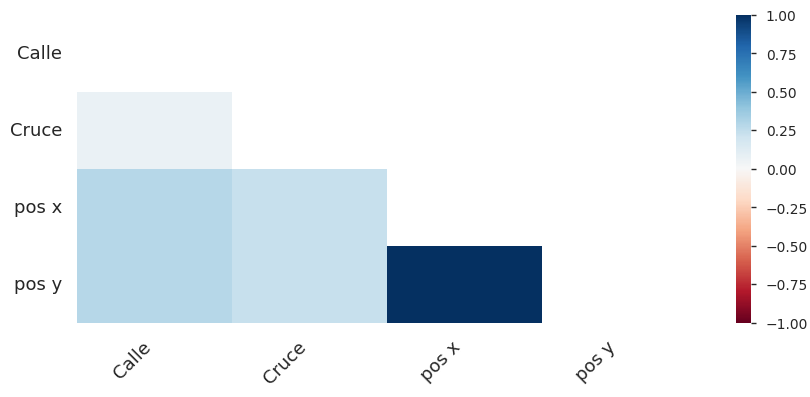

In [48]:
from ydata_profiling import profile_report

profile_report.ProfileReport(data_)

In [47]:
%pip install ipywidgets


   ---------------------------------------- 0.0/139.4 kB ? eta -:--:--
   ----------------- ---------------------- 61.4/139.4 kB 1.1 MB/s eta 0:00:01
   -------------------------------------- - 133.1/139.4 kB 1.6 MB/s eta 0:00:01
   ---------------------------------------- 139.4/139.4 kB 1.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/215.0 kB ? eta -:--:--
   -------------------------------------- - 204.8/215.0 kB 4.1 MB/s eta 0:00:01
   ---------------------------------------- 215.0/215.0 kB 2.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ----- ---------------------------------- 0.3/2.3 MB 9.3 MB/s eta 0:00:01
   ------ --------------------------------- 0.4/2.3 MB 5.0 MB/s eta 0:00:01
   -------------- ------------------------- 0.8/2.3 MB 5.7 MB/s eta 0:00:01
   ------------------ --------------------- 1.1/2.3 MB 5.7 MB/s eta 0:00:01
   ----------------------- ---------------- 1.3/2.3 MB 5.7 MB/s eta 0:00:01
   ------

In [52]:
pd.crosstab(data_['VICTIMA'], data_['ACUSADO'])

ACUSADO      AUTO  BICICLETA  CARGAS  MOTO  MULTIPLE  OBJETO FIJO  OTRO  \
VICTIMA                                                                   
AUTO           31          0      14     0         3           21     1   
BICICLETA       8          0      10     0         1            0     1   
CARGAS          1          0       4     0         0            1     0   
MOTO           83          2      78    25         8           40     4   
MOVIL           0          0       1     0         0            0     0   
OBJETO FIJO     1          0       0     0         0            0     0   
PASAJEROS       1          0       0     0         0            0     0   
PEATON         77          5      38    30         5            0     0   
PEATON_MOTO     0          0       0     1         0            0     0   
SD              2          0       1     1         0            0     0   

ACUSADO      PASAJEROS  SD  TREN  
VICTIMA                           
AUTO                 9   4     0  
BICICLETA            8   0     1  
CARGAS               1   0     0  
MOTO                46   9     0  
MOVIL                1   0     0  
OBJETO FIJO          0   0     0  
PASAJEROS            3   1     0  
PEATON             105   4     0  
PEATON_MOTO          0   0     0  
SD                   0   5     0

In [61]:
data_['ES_CRUCE'] = data_['Cruce'] != 'NA'

In [62]:
data_['ES_CRUCE'].value_counts()

ES_CRUCE
True     525
False    171
Name: count, dtype: int64

In [58]:
data_['Cruce'].fillna('NA', inplace=True)

In [66]:
pd.crosstab(data_['PARTICIPANTES'], data_['ES_CRUCE']).sum()

ES_CRUCE
False    171
True     525
dtype: int64